In [1]:
#Ultra Legendary videos by Digital Seerini on Multi-UNet Model
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


#Build the model
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [11]:
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical

SIZE_X = 128 
SIZE_Y = 128
n_classes=10
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

In [9]:
def load_images(parent_directory, split='train'):
    images = []
    masks = [] 

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)
                
    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [29]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

100%|██████████| 1445/1445 [06:57<00:00,  3.46it/s]


TRAIN: Images loaded: 1445
TRAIN: Masks loaded: 1445


100%|██████████| 450/450 [02:05<00:00,  3.60it/s]

VAL: Images loaded: 450
VAL: Masks loaded: 450


In [30]:
print(f'Images Shape: {train_images[0].shape}')
print(f'Masks Shape: {train_masks[0].shape}')

train_masks = np.expand_dims(train_masks, axis=-1)

print(f'\nImages Shape: {train_images[0].shape}')
print(f'Masks Shape: {train_masks[0].shape}')

Images Shape: (128, 128, 3)
Masks Shape: (128, 128)

Images Shape: (128, 128, 3)
Masks Shape: (128, 128, 1)


In [31]:
train_images = normalize(train_images, axis=1)
val_images = normalize(val_images, axis=1)

In [32]:
train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
train_masks_cat = train_masks_cat.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], n_classes))

val_masks_cat = to_categorical(val_masks, num_classes=n_classes)
val_masks_cat = val_masks_cat.reshape((val_masks.shape[0], val_masks.shape[1], val_masks.shape[2], n_classes))

In [33]:
print(f'\nImages Shape: {train_images[0].shape}')
print(f'Masks Shape: {train_masks_cat[0].shape}')


Images Shape: (128, 128, 3)
Masks Shape: (128, 128, 10)


In [34]:
print(f'\nImages Shape: {val_images[0].shape}')
print(f'Masks Shape: {val_masks_cat[0].shape}')


Images Shape: (128, 128, 3)
Masks Shape: (128, 128, 10)


In [ ]:
# code is not working properly

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_masks), train_masks)
print("Class weights are...:", class_weights)

In [6]:
IMG_HEIGHT = SIZE_X
IMG_WIDTH  = SIZE_Y
IMG_CHANNELS = 3

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [48]:
history = model.fit(train_images, train_masks_cat, batch_size = 16, verbose=1, epochs=50, validation_data=(val_images, val_masks_cat), shuffle=False)

Epoch 1/50
91/91 [==============================] - 12s 55ms/step - loss: 1.8389 - accuracy: 0.4466 - val_loss: 1.6751 - val_accuracy: 0.5455
Epoch 2/50
91/91 [==============================] - 3s 37ms/step - loss: 1.6431 - accuracy: 0.5605 - val_loss: 1.5212 - val_accuracy: 0.5456
Epoch 3/50
91/91 [==============================] - 3s 36ms/step - loss: 1.5768 - accuracy: 0.5619 - val_loss: 1.4690 - val_accuracy: 0.5456
Epoch 4/50
91/91 [==============================] - 3s 36ms/step - loss: 1.5190 - accuracy: 0.5629 - val_loss: 1.4545 - val_accuracy: 0.5456
Epoch 5/50
91/91 [==============================] - 3s 37ms/step - loss: 1.4809 - accuracy: 0.5630 - val_loss: 1.4435 - val_accuracy: 0.5456
Epoch 6/50
91/91 [==============================] - 3s 37ms/step - loss: 1.4756 - accuracy: 0.5630 - val_loss: 1.4498 - val_accuracy: 0.5456
Epoch 7/50
91/91 [==============================] - 3s 36ms/step - loss: 1.4425 - accuracy: 0.5643 - val_loss: 1.4185 - val_accuracy: 0.5456
Epoch 8/50
9

In [54]:
model.save('UNet_model_with_50_epochs.hdf5')

In [7]:
model.load_weights('UNet_model_with_50_epochs.hdf5')

In [73]:
test_images, test_masks = load_images(parent_directory, split='test')
test_masks = np.expand_dims(test_masks, axis=-1)
test_masks_cat = to_categorical(test_masks, num_classes=n_classes)
test_masks_cat = test_masks_cat.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], n_classes))
test_images_seperate = test_images
test_images = normalize(test_images, axis=1)

print(f'\nImages Shape: {test_images[0].shape}')
print(f'Masks Shape: {test_masks_cat[0].shape}')

100%|██████████| 448/448 [02:00<00:00,  3.71it/s]


TEST: Images loaded: 448
TEST: Masks loaded: 448

Images Shape: (128, 128, 3)
Masks Shape: (128, 128, 10)


In [13]:
_, acc = model.evaluate(test_images, test_masks_cat, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  60.36848425865173 %


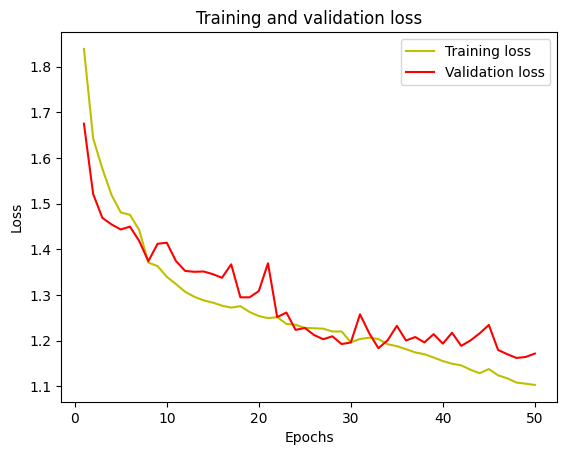

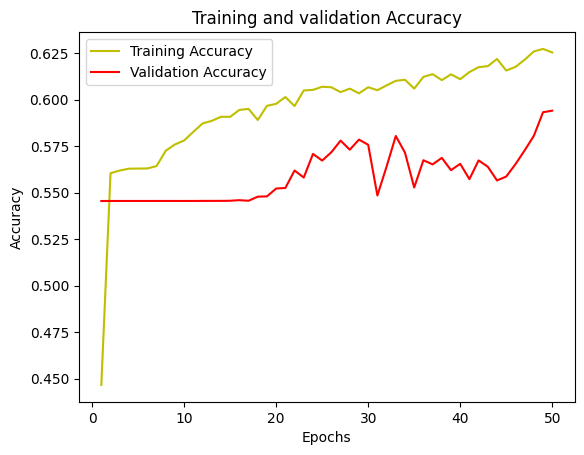

In [53]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
y_pred_argmax = np.argmax(y_pred, axis=3)
predicted_masks = np.argmax(y_pred, axis=-1)
predicted_masks = np.expand_dims(predicted_masks, axis=-1)

class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

class_IoUs = []
for i in range(n_classes):
    class_IoU = values[i, i] / np.sum(values[i, :])
    class_IoUs.append(class_IoU)
    print(f"IoU for class {class_names[i]} is: {class_IoU}")

print("Overall mean IoU =", np.mean(class_IoUs))

14/14 [==============================] - 1s 38ms/step
Mean IoU = 0.12694836
IoU for class Background is: 0.0
IoU for class Building Flooded is: 0.00034208287252113223
IoU for class Building Non-Flooded is: 0.0
IoU for class Road Flooded is: 0.0
IoU for class Road Non-Flooded is: 0.6084924936294556
IoU for class Water is: 0.39371511340141296
IoU for class Tree is: 0.07589609920978546
IoU for class Vehicle is: 0.0
IoU for class Pool is: 0.0
IoU for class Grass is: 0.9201056957244873
Overall mean IoU = 0.19985516


In [84]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

def display_images_with_masks(image, mask, predicted):
    
    class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

    color_map = {
        "Background": [0, 0, 0],
        "Building-flooded": [255, 0, 0],
        "Building-non-flooded": [0, 255, 0],
        "Road-flooded": [0, 255, 120],
        "Road-non-flooded": [0, 0, 255],
        "Water": [255, 0, 255],
        "Tree": [70, 70, 70],
        "Vehicle": [102, 102, 156],
        "Pool": [190, 153, 153],
        "Grass": [180, 165, 180]
    }

    handles = [
        Rectangle((0, 0), 1, 1, color=np.array(c)/255) for n, c in color_map.items()
    ]
    labels = [n for n, c in color_map.items()]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.title('Image')

    plt.subplot(1, 3, 2)
    mask_colored = np.zeros_like(image, dtype=np.uint8)
    for class_name, class_idx in class_map.items():
        color = color_map[class_name]
        mask_indices = np.where(mask == class_idx)
        mask_colored[mask_indices[0], mask_indices[1], :] = color
    plt.imshow(cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB))
    plt.title('Ground-Truth Mask')

    plt.subplot(1, 3, 3)
    mask_colored1 = np.zeros_like(image, dtype=np.uint8)
    for class_name1, class_idx1 in class_map.items():
        color1 = color_map[class_name1]
        mask_indices1 = np.where(predicted == class_idx1)
        mask_colored1[mask_indices1[0], mask_indices1[1], :] = color1
    plt.imshow(cv2.cvtColor(mask_colored1, cv2.COLOR_BGR2RGB))
    plt.title('Predicted Mask')

    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128, 1)
Predicted Mask Shape: (128, 128, 1)


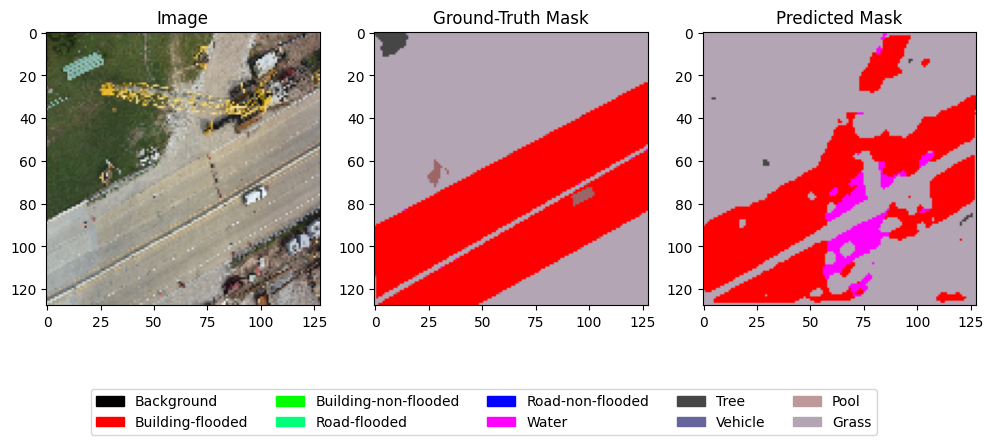

In [92]:
image_id = 13
image = test_images_seperate[image_id]
ground_truth_mask = test_masks[image_id]
predicted_mask = predicted_masks[image_id]

print(f'Image Shape: {image.shape}')
print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
print(f'Predicted Mask Shape: {predicted_mask.shape}')

display_images_with_masks(image, ground_truth_mask, predicted_mask)